<a href="https://colab.research.google.com/github/kelleyl54/DSPS_LKelley/blob/master/HW3_lKelley/DSPS_HW3_1_lKelley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by FedericaBBianco @fedhere September 2019 for UDel PHYS467/667
# Kolmogorov Smirnoff test, application to earthquake data

In [47]:
#all the imports I needed
from __future__ import print_function, division
import pandas as pd
import pylab as pl
import scipy as sp
from scipy import stats
%pylab inline
pl.style.use("https://raw.githubusercontent.com/fedhere/DSPS/master/fbb.mplstyle")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


This homework asks you to reproduce the work in [Corral 2018](https://arxiv.org/pdf/0910.0055.pdf) which is well described, but not "reproducible". 
Corral 2018 uses a K-S test to show that at different magnitude scales the time gaps between earthquakes follows the same distribution. If true, this indicates that there is a consistent scaling law. 

The argument is a little convoluted, but it is a somewhat innovative use of the test. Corall compares the time gap between earthquakes  greater than a certain magnitude threshold with the time gaps between earthquakes above a different threshold, and finds no differences.

Remind yourself exactly what the K-S test is about :

    1 What is the test's Null Hypothsis that the K-S test tests?
    
    





The Null Hypothesis of the K-S test asserts that two samples of data come from the same parent distribution.

    2 What is the "statistic" or "pivotal quantity" that the test uses?
    





The statistic that the K-S compares is the maximum distance between the two cumulative distributions of the two samples.


    3 What does the probability distribution of this statistic depend on? 
    
   



As stated before, this statistic depnds on the separation between two samples and the size of the samples. It is also fairly biased to notice discrepancies in the distributions more towards the middle of the cumulative space compared to the ends of the cumulative distribution.    

# Data Retrival

The first reason why the paper is not techincally _reproducible_ is that, while a link is provided to retrieve the data, the link is dead. This happens often. Services like [Zenodo](https://zenodo.org/) or journals that serve data provide some insurance against this but unfortunately the standards are not strict. 

If you are taking this class as 667 retrieve the data yourself from [this website](http://service.scedc.caltech.edu/eq-catalogs/poly.php). Make sure the number of entries in your final dataset is similar to that of the authors. I got 70798, instead of 77000. 10% off, which I deem close enough. You should get something similar. Use the map in the paper to determine the region of interest. Call the file earthquakes_\<firstinitialLastname\>.csv and upload it to your github repository. Read it your file, instead of mine as instructed below. If you are getting weird results compare to what I got, go back and check how the files differ.

# Data Ingestion

## read in data

I saved the data in a file called "earthquakes.csv", where ```csv``` stands for "comma separated file". [This file format](https://www.howtogeek.com/348960/what-is-a-csv-file-and-how-do-i-open-it/) requires different entries in a row to be separated by commas alone (no space) and for commas to be used in quote if they are not intended to separate entries. 

```
a,b,c
d,e,f
g,"h,2",i
```
The data is uploaded on the  github homework repository but to read it in you will need to get the link to the *raw file*: the link to the file https://github.com/fedhere/DSPS/blob/master/HW3/earthquakes.csv  takes you to an ```html``` page that includes the content of the file, but you want to isolate the content of the file itself: the _raw file_. Pay attention to this: from the next time I will not give you the exact link, I will just point you to the file and you will have to find the link to the raw data from there. 
https://raw.githubusercontent.com/fedhere/DSPS/master/HW3/earthquakes.csv

The data can be read effectively using the _pandas_ python package as ```pandas.read_csv(<file name or URL>)```. 

However, I did not format the data correctly, according to the csv extension requirement. This happens all the time. Look at the file and use the pandas documentation to figure out how to read it with ```pd.read_csv()```

In [0]:
#importing the raw data, taking into account that the data is separated by a space, not a comma
eqdata=pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS/master/HW3/earthquakes.csv", delimiter=" ")

running the following lines of code should give you the same result as mine if you used the file I provided (467 students), and qualitatively  similar if you are using your own data (667 students)

In [49]:
eqdata.shape

(70798, 34)

In [50]:
eqdata.head()

,#YYY/MM/DD,HH:mm:SS.ss,ET,GT,MAG,Unnamed: 5,M,Unnamed: 7,Unnamed: 8,Unnamed: 9,LAT,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,LON,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,DEPTH,Q,Unnamed: 25,EVID,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,NPH,NGRM
0,1984/01/01,01:30:57.52,eq,NaN,l,2.02,c,NaN,NaN,33.246,-116.433,NaN,NaN,1.6,C,NaN,NaN,NaN,28255.0,NaN,NaN,13.0,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1984/01/01,05:31:34.16,eq,NaN,l,2.12,c,NaN,NaN,32.945,-116.295,NaN,NaN,5.4,C,NaN,NaN,NaN,28259.0,NaN,NaN,18.0,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1984/01/01,06:59:05.14,eq,NaN,l,2.43,c,NaN,NaN,33.343,-117.628,NaN,NaN,5.6,C,NaN,NaN,NaN,28260.0,NaN,NaN,13.0,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1984/01/01,11:10:25.29,eq,NaN,l,2.07,c,NaN,NaN,33.668,-116.780,NaN,13.8,C,NaN,NaN,NaN,28270.0,NaN,NaN,19.0,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1984/01/01,19:38:19.79,eq,NaN,l,2.13,c,NaN,NaN,33.963,-116.290,NaN,NaN,2.7,C,NaN,NaN,NaN,28553.0,NaN,NaN,40.0,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
eqdata.describe()

,GT,Unnamed: 5,Unnamed: 7,Unnamed: 8,Unnamed: 9,LAT,Unnamed: 11,Unnamed: 12,Unnamed: 15,Unnamed: 16,LON,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,DEPTH,Q,Unnamed: 25,EVID,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,NPH,NGRM
count,0.0,70798.000000,0.0,0.0,70798.000000,70798.00000,0.0,9648.000000,7.359000e+03,4.628900e+04,14096.000000,10889.000000,43932.000000,21302.000000,33735.000000,18080.000000,12705.000000,3387.000000,469.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,2.417826,NaN,NaN,33.977749,-116.88145,NaN,13.354343,6.097558e+06,4.482677e+06,524649.772205,16307.082193,43.634321,141.903530,203.562443,78.426383,55.085714,43.415412,14.746269,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.407683,NaN,NaN,1.156586,1.07667,NaN,2.724517,4.441852e+06,3.130379e+06,281055.136911,25237.230734,121.795817,311.415589,155.337382,56.105321,30.519535,24.266088,17.013243,2.828427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2.000000,NaN,NaN,30.094830,-121.76000,NaN,10.000000,1.000432e+06,1.070000e+02,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.120000,NaN,NaN,33.061000,-117.69200,NaN,11.200000,3.041641e+06,3.031237e+06,136998.250000,27.000000,18.000000,14.000000,113.000000,48.000000,33.000000,24.000000,0.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.300000,NaN,NaN,34.056750,-116.59000,NaN,12.800000,3.229114e+06,3.110080e+06,703081.500000,57.000000,28.000000,23.000000,168.000000,70.000000,50.000000,38.000000,13.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2.590000,NaN,NaN,34.591000,-116.25100,NaN,14.900000,9.669999e+06,9.027968e+06,725926.500000,37764.000000,42.000000,137.000000,294.000000,92.000000,71.000000,61.000000,24.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,7.100000,NaN,NaN,37.985500,-113.71900,NaN,29.300000,3.736673e+07,9.875061e+06,754723.000000,71774.000000,3384.000000,3815.000000,1574.000000,996.000000,227.000000,145.000000,88.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


now that you have a dataframe object you can use methods of the object to modify it. Use the method ```eqdata.rename``` to change the names of the 3 columns that are the only three relevant to us: _date, time, magnitude_

## prepare date-time column

In [0]:
#renaming the columns and culling the dataframe down to three columns
eqdata.rename(columns = {'#YYY/MM/DD':'date','HH:mm:SS.ss':'time','Unnamed: 5':'magnitude'},inplace=True)
eqdata=eqdata[['date','time','magnitude']]

In [53]:
eqdata.head()

,date,time,magnitude
0,1984/01/01,01:30:57.52,2.02
1,1984/01/01,05:31:34.16,2.12
2,1984/01/01,06:59:05.14,2.43
3,1984/01/01,11:10:25.29,2.07
4,1984/01/01,19:38:19.79,2.13


In [54]:
eqdata.describe()

,magnitude
count,70798.000000
mean,2.417826
std,0.407683
min,2.000000
25%,2.120000
50%,2.300000
75%,2.590000
max,7.100000


Now you want to combine the columns containing date and time and convert them to a "datetime" kind of data object. 


What data type are the _time_ and _date_ columns right now? What tyoe you want them to be to conver them to datetime with ```pd.datetime()```?

In [55]:
eqdata.time.dtype, eqdata.date.dtype

(dtype('O'), dtype('O'))

to do this conversion I 

   1 joined date and time into a single string for each row with a ["list comprehension"](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python) (essentially a for loop but more efficient and compact). You do not have to do it with a list comprehension, you can use just a for loop.

   2 used pd.datetime() to convert the resulting new dataframe column into a dataframe column containing _datetime_ objects (see lab)

   3 but this did not work because of the formatting of some dates, so I had to go back and fix 5 entries. (you are on your own to figure out this one)

In [56]:
#combining the two columns for datetime together as string
eqdata['datetime']=eqdata['date']+' '+eqdata['time'];

#converting the strings into datetime objects
eqdata['datetime']=pd.to_datetime(eqdata.datetime,errors='coerce')

indexlist=range(0,70798)

#looking for the 5 erroroneous values, observing the rows in the dataframe, and dropping those rows from the collection of data
#since it's only five points out of the whole set of over 70000 points, we can remove those points without gravely affecting the results 
for i in indexlist:
  if pd.isnull(eqdata.datetime[i])==True:
    print(indexlist[i])
    print(eqdata.loc[i])
    eqdata = eqdata.drop([i],axis=0)

1723
date          1984/08/09
time         04:48:60.00
magnitude           2.32
datetime             NaT
Name: 1723, dtype: object
25538
date          1990/12/25
time         14:19:60.00
magnitude           2.05
datetime             NaT
Name: 25538, dtype: object
34227
date          1992/07/10
time         21:48:60.00
magnitude           2.62
datetime             NaT
Name: 34227, dtype: object
50211
date          1995/07/08
time         15:34:60.00
magnitude           2.05
datetime             NaT
Name: 50211, dtype: object
59503
date          1999/08/14
time         06:41:60.00
magnitude              2
datetime             NaT
Name: 59503, dtype: object


We chose to simply drop the five problematic values from our sample based on the overall sample size. With more than 70000 original samples, the removal of an extra five of the samples should not cause a significant difference in the presentation of the results.

In [57]:
#demonstrating that the five problem columns have been removed
len(eqdata.datetime)

70793

In [58]:
eqdata.head()

,date,time,magnitude,datetime
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790


## select valuable data

Following the description in Section 2  of Corral 2018 I removed all data that did not belong to a "stationary" period. Third paragraph section 2 of Corral 2018. You can see the cell of code I used to do this [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_selectStationary.py) at no points cost, cause it was a bit tricky, but I encourage you to try and do it yourself. If you can do it in fewer lines than I did its automatically +5 points (just turning the loop into a list comprehension does not count. That is an obvious way to decrease the number of lines of code; I did not do it simply to enhance readability.)

In [59]:
#this are snippits of code. This is not intended as a script that should run on its own.

# first I create the timetamps pairs for the beginning and end of the valid periods. 
# I do it with a for loop that appends pairs of timestamps to a list that I create at the beginning

############
# create empty container
ss = []

# loop through all year pairs as year and fraction of year
for t in [(1984, 1986.5), 
          (1990.3, 1992.1), 
          (1994.6, 1995.6),
          (1996.1,1996.5), 
          (1997,1997.6), 
          (1997.75,1998.15), 
          (1998.25,1999.35), 
          (2000.55,2000.8),
          (2000.9 ,2001.25), 
          (2001.6 ,2002), 
          (2002.5 ,2003)]:
    
    # for each pair I convert the year to datetime (easy)
    # then I convert the fraction of year and convert it to days and convert that to a delta-time
    # finally I add that deltatime to the year datetime. 
    ss.append((pd.to_datetime(int(t[0]), format="%Y") 
        + pd.Timedelta('%.f days'%((t[0] - int(t[0])) * 365.25)),
               pd.to_datetime(int(t[1]), format="%Y") 
        + pd.Timedelta('%.f days'%((t[1] - int(t[1])) * 365.25))))


############

print ("the {} timestamp pairs that are the boundaries of good data periods are:".format(len(ss)))


############

# data between start and end of first time period
gooddates = (((eqdata.datetime >= ss[0][0]) & (eqdata.datetime <= ss[0][1])) |\
        # data between start and end of second time period
        ((eqdata.datetime >=ss [1][0]) & (eqdata.datetime <= ss[1][1])) |\
        ((eqdata.datetime >=ss [2][0]) & (eqdata.datetime <= ss[2][1])) |\
        ((eqdata.datetime >=ss [3][0]) & (eqdata.datetime <= ss[3][1])) |\
        ((eqdata.datetime >=ss [4][0]) & (eqdata.datetime <= ss[4][1])) |\
        ((eqdata.datetime >=ss [5][0]) & (eqdata.datetime <= ss[5][1])) |\
        ((eqdata.datetime >=ss [6][0]) & (eqdata.datetime <= ss[6][1])) |\
        ((eqdata.datetime >=ss [7][0]) & (eqdata.datetime <= ss[7][1])) |\
        ((eqdata.datetime >=ss [8][0]) & (eqdata.datetime <= ss[8][1])) |\
        ((eqdata.datetime >=ss [9][0]) & (eqdata.datetime <= ss[9][1])) |\
        # data between start and end of last time period
        ((eqdata.datetime >=ss [10][0]) & (eqdata.datetime <= ss[10][1])\
        ).values)
gooddates

the 11 timestamp pairs that are the boundaries of good data periods are:


0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
         ... 
70768    True
70769    True
70770    True
70771    True
70772    True
70773    True
70774    True
70775    True
70776    True
70777    True
70778    True
70779    True
70780    True
70781    True
70782    True
70783    True
70784    True
70785    True
70786    True
70787    True
70788    True
70789    True
70790    True
70791    True
70792    True
70793    True
70794    True
70795    True
70796    True
70797    True
Name: datetime, Length: 70793, dtype: bool

The following cell of code shows you the array of bool values (True/False) which I create to use as an index to the input array: when used as an index, a technique called "broadcasting" in python, will select only elements of the original array where the index array value is True. something like 
Try:



In [60]:
a = np.array([0, 1, 2])
a, a[[True, False, True]]

(array([0, 1, 2]), array([0, 2]))

For each of the 11 valid periods I create a condition 
``` datetime >= period_start AND datetime <= period_end ``` where AND is a product of booleans: True * False = False.

I want to take all chinks of data that satisfy this condition for any of the 11 chunks of time so that is a logical OR operator, or a sum of Booleans: True + False = True 

This is because ```True``` really corresponds to "not 0" and False to "0". So ```"not 0" * 0 = 0``` and ```"not 0" + 0 = not 0```
    

In [61]:
print ("there are {} earthquakes falling in the selected stationary periods".
       format(gooddates.sum()))

there are 18849 earthquakes falling in the selected stationary periods


In [0]:
# your code here: broadcasting to create a dataframe with the good dates only
eqGoodData=eqdata[gooddates]

In [63]:
eqGoodData.shape

(18849, 4)

In [64]:
eqGoodData.head()

,date,time,magnitude,datetime
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790


Now what you really want is the _time interval between earthquakes_ for all events greater than some magnitude m, while all you have are the date and time of the events.: 

You can remove earthquakes smaller than magnitude 2 by, again, broadcasting. How would that look like?

In [65]:
eqGoodData.shape #look like for my data it was not needed! that is because I chose M>2 when when I downloaded the data

(18849, 4)

You can get the time between consecutive earthquakes with the method ```diff()``` of numpy arrays (in a pandas series you can get the data as a numpy array with the attribute .values: ```seried.values```). 


In [66]:
#creating the gap column in the DataFrame
array1=np.diff(pd.Series(eqGoodData.datetime).array)
array1=np.insert(array1,0,0,axis=0)
array1.astype(int)
eqGoodData['gap']=array1.astype(int)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [67]:
len(array1)
len(eqGoodData)

array1
len(array1)

18849

In [68]:
#showing that the new column has been created
eqGoodData.head()

,date,time,magnitude,datetime,gap
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520,0
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,14436640000000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,5250980000000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,15080150000000
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,30474500000000


In [69]:
eqGoodData.shape

(18849, 5)

In [70]:
eqGoodData.head()

,date,time,magnitude,datetime,gap
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520,0
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,14436640000000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,5250980000000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,15080150000000
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,30474500000000


In [71]:
eqGoodData.describe()

,magnitude,gap
count,18849.000000,1.884900e+04
mean,2.399529,3.180661e+13
std,0.392451,1.104014e+15
min,2.000000,0.000000e+00
25%,2.110000,2.736680e+12
50%,2.290000,8.946280e+12
75%,2.570000,2.133959e+13
max,5.800000,1.199632e+17


Note that the first entry will be NaT which is Not a Time (corresponding to nan for numerical variables) or maybe a negative number (depends on your exact operations above). You should remove it

**Note:** Our first entry was manually entered as 0 to keep the number of entries in each column the same. Then the whole first column was removed.

In [0]:
#removing the first entry
eqGoodData=eqGoodData.drop([0],axis=0)

In [73]:
eqGoodData.head()

,date,time,magnitude,datetime,gap
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,14436640000000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,5250980000000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,15080150000000
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,30474500000000
5,1984/01/01,19:39:19.67,2.13,1984-01-01 19:39:19.670,59880000000


# data exploration
At this point you should wonder if this is the final dataset that you want to use and if anything is weird or suspicious about it. Visualize the distribution. A good way to visualize distributions is a histogram which you can prodice with pl.hist() or as a method of your dataframe series as ```df[SeriesName].plot(kind="hist")```. Produce a plot like the one below (label the axis! and describe it with a caption!). To get the logarithmic y axis you can se ```logy=True```, for example. in your ```df[SeriesName].plot``` call.

Text(0, 0.5, 'Frequency')

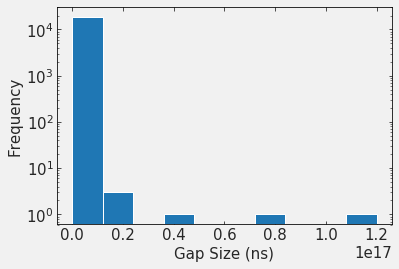

In [74]:
#histogram with the data so far
pl.hist(eqGoodData['gap'],log=True)
pl.xlabel('Gap Size (ns)')
pl.ylabel('Frequency')


**Figure 1: The distribution of gap sizes for all acceptable data in the stationary time periods described in the paper, plotted in a log space. There are a few gaps much larger than the majority of the sample, due to the beginning of one stationary period happening months after the end of the previous period.**

The thing that worries me is that by removing some sections of the data to use only stationary periods we created some artificially large gaps: gaps of order ~month. How many nanoseconds in a month? remove all gaps that are larger than about a month and see how the distribution looks (make another histogram).

In [75]:
# one month is roughly 2.6 e15 ns
# removing gaps which are on the order of a month
eqGoodData=eqGoodData[eqGoodData.gap <= 2.6*10**15]
eqGoodData.describe()

,magnitude,gap
count,18838.000000,1.883800e+04
mean,2.399654,1.554381e+13
std,0.392513,1.880540e+13
min,2.000000,1.700000e+08
25%,2.110000,2.736248e+12
50%,2.290000,8.938365e+12
75%,2.570000,2.129848e+13
max,5.800000,2.365828e+14


Text(0, 0.5, 'Frequency')

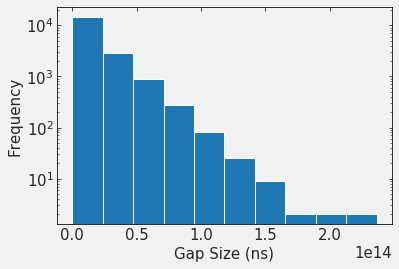

In [76]:
#creating a histogram of the culled data
pl.hist(eqGoodData['gap'],log=True);
pl.xlabel('Gap Size (ns)')
pl.ylabel('Frequency')

**Figure 2: A revised historgram of the frequency of gap sizes with gaps larger than a month removed from the sample. Again, this histogram is plotted in a log space. Now many of the gaps are within 2-3 orders of magnitude and are not skewed by the differences between stationary periods.**

# data analysis

### important: the paper does not do it but I want you to formally choose a threshold before you do this test. Choose a p-value (=$\alpha$ thresold: call your variable ```alpha```) of 3-$\sigma$.

Follow the instructions (algorithm) in **Section 3 paragraph 3** and compare your results with the results in table 1 with a threshold  of = 0.01 and 0.001

Do it for all 5 magnitude thresholds as indicated in the paper (and in Table 1).

Note that the x axis in plot Fig 1 is in _log space_. Use ```np.log10()``` to take the logarithm of the time gaps.

The pseudocode for the algorithm is [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_pseudocode.md).


In [77]:
alpha = 1-0.9973
alpha
#the alpha value for 3-sigma

0.0027000000000000357

If any p-values returned are less than the above alpha value, we should reject the Null Hypothesis for that set. 

Reproduce the paper Fig 1 and Table 1. In the Table report the size of each dataset after cleaning the value of the statistic and the p-value, as done in Corral 2018. Use the scipy function for the 2 sample KS test. (resources [here](https://colab.research.google.com/notebooks/markdown_guide.ipynb#scrollTo=70pYkR9LiOV0) to learn about the table syntax in markdown)

In [78]:
eqGoodData.head()

,date,time,magnitude,datetime,gap
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,14436640000000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,5250980000000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,15080150000000
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,30474500000000
5,1984/01/01,19:39:19.67,2.13,1984-01-01 19:39:19.670,59880000000


In [79]:
#realization of the given pseudocode algorithm, implemented mainly by S.F.
#returns means to compare to 1 and each K-S test to later put into the table
thresholds = [0.01,0.001]
mag_list = [2.0,2.5,3.0,3.5,4.0]

x_mk=np.empty([len(mag_list),len(thresholds)],dtype='O')

#print(x_mk)

for threshold in thresholds:
  for mk in range(len(mag_list)):
    x_mk[mk][thresholds.index(threshold)]=eqGoodData.gap.where(eqGoodData.magnitude>mag_list[mk]).dropna()
    for _ in [1,2]:
      rk = 1/np.mean(x_mk[mk][thresholds.index(threshold)])
      print(rk)
      x_mk[mk][thresholds.index(threshold)] = x_mk[mk][thresholds.index(threshold)].where(x_mk[mk][thresholds.index(threshold)]*rk>threshold).dropna()*rk
      print(str(np.mean(x_mk[mk][thresholds.index(threshold)]))+'\n')
    #there were two lines in the pseudocode that were unnecessary, but I'll do them anyways.
    #rk = 1/np.mean(x_mk[mk][threshold])
    #x_mk[mk][threshold] = x_mk[mk][threshold]*rk
      
    print("\n\n")
#  print(x_mk[2][threshold])
  for mk in range(len(mag_list)):
    for ml in range(mk+1,len(mag_list)):
      print(mk,ml)
      print(stats.ks_2samp(x_mk[mk][thresholds.index(threshold)].values,x_mk[ml][thresholds.index(threshold)].values),"\n")
      
      
for i in [0,1,2,3,4]:
  for j in [0,1]:
    print(len(x_mk[i][j]))
        
        

6.434755053043147e-14
1.047920780923528

0.9542706072864633
1.0009226781298688




6.796399868587622e-14
1.0589242145947533

0.9443546442865098
1.0017146513830506




6.950308020104612e-14
1.0802470355539338

0.9257141811893199
1.0030191777186424




6.749924371256141e-14
1.0929032449127007

0.9149940808162559
1.0025721253373236




5.862185852912074e-14
1.0823473995713828

0.9239177739014359
1.0185098178118415




0 1
Ks_2sampResult(statistic=0.015247629434355287, pvalue=0.31160764333837937) 

0 2
Ks_2sampResult(statistic=0.02299262724588108, pvalue=0.5397143511869957) 

0 3
Ks_2sampResult(statistic=0.06387513831460023, pvalue=0.09257997807311825) 

0 4
Ks_2sampResult(statistic=0.1047685812364576, pvalue=0.1935582269890511) 

1 2
Ks_2sampResult(statistic=0.017831377452866486, pvalue=1.0) 

1 3
Ks_2sampResult(statistic=0.05624041214652988, pvalue=0.1986587555511784) 

1 4
Ks_2sampResult(statistic=0.10343662012348387, pvalue=0.19748021731085785) 

2 3
Ks_2sampResult(statistic=0.05503840

The above results show that every data set is normalized to a mean of 1 for Rk, as described in the paper. Each KS test's results are also printed.

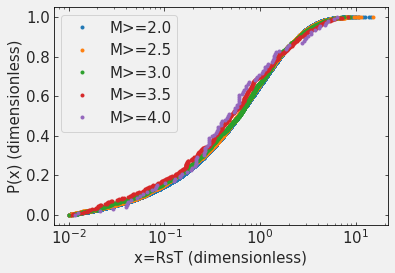

In [80]:
#generating the figure from the paper in the cumulative space
x_mk_sort= np.zeros_like(x_mk)
for i in range(len(x_mk)):
  for j in range(len(x_mk[i])):
    x_mk_sort[i,j] = np.sort(x_mk[i,j].values)

for i in range(len(x_mk_sort)):
  pl.plot(x_mk_sort[i][0],np.linspace(0,1,num=len(x_mk_sort[i][0])),'.')
  
pl.xscale('log')
pl.xlabel("x=RsT (dimensionless)")
pl.ylabel("P(x) (dimensionless)")
pl.legend(["M>=2.0","M>=2.5","M>=3.0","M>=3.5","M>=4.0"])

**Figure 3: A reproduction of Figure 1 from the Corral paper. Note how all of the curves, which represent the sets of rescaled data, follow a similar cumulative distribution. This indicates that the data sets for the intervals between earthquakes of certain magnitudes follows a scaling law depending on the magnitude.**

$m=0.01$|$N$|$M\geq2.0$|$M\geq2.5$|$M\geq3.0$|$M\geq3.5$|$M\geq4.0$|
---|---|---|---|---|---|---
$M\geq2.0$|$17171$|$-$|$31.2\%$|$54.0\%$|$9.3\%$|$19.4\%$
$M\geq2.5$|$5198$|$0.015$|$-$|$100.0\%$|$19.9\%$|$19.7\%$
$M\geq3.0$|$1312$|$0.023$|$0.018$|$-$|$31.4\%$|$17.6\%$
$M\geq3.5$|$385$|$0.064$|$0.056$|$0.055$|$-$|$84.9\%$
$M\geq4.0$|$107$|$0.105$|$0.103$|$0.109$|$0.065$|$-$

$m=0.001$|$N$|$M\geq2.0$|$M\geq2.5$|$M\geq3.0$|$M\geq3.5$|$M\geq4.0$|
---|---|---|---|---|---|---
$M\geq2.0$|$17890$|$-$|$6.9\%$|$9.2\%$|$4.9\%$|$15.6\%$
$M\geq2.5$|$5465$|$0.020$|$-$|$100.0\%$|$16.0\%$|$17.6\%$
$M\geq3.0$|$1402$|$0.034$|$0.024$|$-$|$35.0\%$|$20.5\%$
$M\geq3.5$|$415$|$0.068$|$0.057$|$0.051$|$-$|$80.8\%$
$M\geq4.0$|$113$|$0.107$|$0.103$|$0.103$|$0.066$|$-$

**Table 1: A reproduction of Table 1 from the Corral paper, with results presented from our own analysis of the K-S test for different samples at different magnitude cutoffs. As in the figure in the paper, values below the diagonal of the table are the statistic used in the K-S test for each set of data (the maximum distance between each distribution in cumulative space.) The values above the diagonal are the p-value for each test as a percentage.**

Did you find any statistical significant differences between the distributions? What does it mean? Is your result identical to Correll's 2018? Why or why not? **Discuss!**

# Discussion
Our results were not identical to the results obtained in the Coral paper, but they did provide information that allows us to draw similar conclusions. Through working with the data on our own and performing the K-S test on all of the combinations of data sets, we agreed with the premise of a scaling law. Our previously selected alpha value of 3-sigma results in a comparison for the p-value of 0.27%. As seen above in Table 1, no two combinations of data sets produced a p-value less than 3-sigma when the K-S test was applied. This means that the Null Hypothesis of all the K-S tests cannot be rejected, but this was actualy the result that the original paper set out to prove. If the Null-Hypothesis for this test is not rejected, it means that the two samples in question likely come from the same distribuion. Since each sample had previously been normalized by a scale factor, saying that two of the magnitude-gap samples come from the same parent distribution is equivalent to saying that there is a scaling law present in how the gap between earthquakes above a certain magnitude scales with the limit chosen for the cutoff magnitude. 

Figure 3, which is a reproduction of Figure 1 from the original paper, is visual confirmation of the results from the K-S tests previously described. By observing the figure, one can see that each curve, which represents a set of normalized data, follows the same distribution. Again, this is evidence that a scaling law for the gap sizes between earthquakes is present.

Although we drew the same conclusions as the original paper, the exact values for Table 1 and the cumulative space distributions for Figure 1 were not exactly the same as from the original source. Of course, we did not have every exact step in the data analysis and the exact data used available to us, which explains the discrepancies. Nevertheless, the process for data analysis was followed as closely as possible from the paper's instructions, and we were able to draw the same conclusions and demonstrate the presence of a scaling law for this physical phenomenom.

### 667 students ( or extra credits)

Organize your result for different magnitude threshold in a numpy array (it should be a 5x5 array) for both cutoffs (0.01 and 0.001). Each of these arrays should contain the p-value for the pair of distributions i,j in cell \[i\]\[j\] and \[j\]\[i\]. Use ```imshow``` to visualize this 2D data. FIrst visualize the matrix itself as done below.

In [81]:
# your code here
        
pl.imshow((ks_001));
pl.axis('off')
cb = pl.colorbar()
cb.ax.set_ylabel(r'$p$-value')
pl.title("KS test results");
#add a caption

NameError: ignored


Now visualize the result as a matrix where the cells are white if the results is not statistically significant and red otherwise. 
After doing it fot the set alpha threshold, lower your alpha threshold so that at least one pair of distribution has a statistically significant difference. **Warning!! this is an unethocal horrifying practice! Once you chose your significance threshold you are never allowed to change it! Why? Discuss**

Redoing it for threshold 0001